In [363]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [364]:
from sklearn.model_selection import learning_curve, validation_curve, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

In [365]:
from ml_utils import plot_learning_curve
from prepare_data import assign_class, lag

In [427]:
df = pd.read_csv('data/los_angeles_weather_pm25.csv')
df = df.rename(mapper={'Unnamed: 0': 'DATE'}, axis='columns')
df = df[df.PM25 < 400]
df = df[df.PM25 > 0]

In [429]:
df = df.set_index(pd.to_datetime(df['DATE']))

In [430]:
df['DOW'] = df.index.dayofweek
df['HOUR'] = df.index.hour
df['MONTH'] = df.index.month
df['WEEKDAY'] = df.DOW.between(0, 4)

In [431]:
df = lag(df, 'PM25', lags=[1])

In [432]:
df = df.dropna(axis='rows')

In [433]:
columns = list(df.columns)
columns.remove('DATE')
columns.remove('PM25')
print(columns)
X = df[columns].values
#y = df['class'].values
y = df['PM25'].values

['SLP', 'SPD', 'DIR', 'TMP', 'DEW', 'MONTH', 'HOUR', 'DOW', 'WEEKDAY', 'PM25_1']


In [434]:
print(X.shape, y.shape)

(15383, 10) (15383,)


In [435]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)

In [436]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
#dvalid = xgb.DMatrix(X_valid, label=y_valid)

In [437]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ['auc', 'error']
param = {'max_depth': 3,
        'eta': 0.3,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'verbose': False,
        'objective': 'reg:linear',
        }#'num_class': 2,
        #'eval_set': eval_set,
        #'eval_metric': eval_metric}
nrounds = 20

In [438]:
bst = xgb.train(param, dtrain, nrounds) #, evals=[(dvalid, 'auc'), (dvalid, 'err')])

[09:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:34:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:34:44] /work

In [439]:
y_pred = bst.predict(dtest)

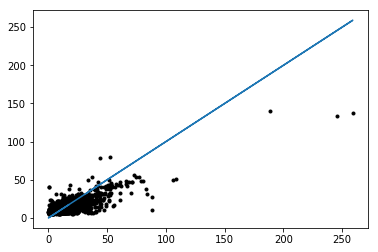

In [440]:
plt.plot(y_test, y_pred, 'k.')
plt.plot(y_test, y_test, '-')

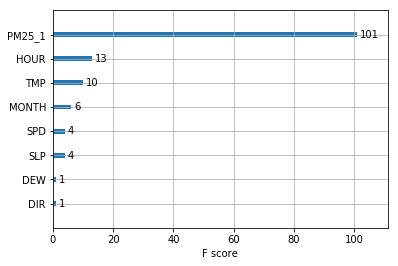

In [441]:
bst.feature_names = columns
xgb.plot_importance(bst, ylabel='', title='')